In [19]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

# Silence pipeline init logs unless overridden upstream
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_models as mndws_models

mndws_models.set_seed(1337)
device = mndws_models.device
use_cuda = mndws_models.use_cuda
use_mps = mndws_models.use_mps
print("Device:", device)

Device: mps


In [20]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = mndws_models.configure_channels()
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=CHANNELS_FOR_MODEL,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [21]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 21 pos_weight = 32.9764289855957


In [22]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt
import time

def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader, *, model=None, desc=None):
    model = lr_model if model is None else model
    model.eval()
    all_p, all_t = [], []
    iter_desc = desc if desc is not None else "eval LR"
    for b in tqdm(loader, desc=iter_desc, leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    yhat = (p >= best_thr).astype(np.float32)
    intersection = float((yhat * t).sum())
    union = float(yhat.sum() + t.sum() - intersection)
    iou = intersection / (union + 1e-8)
    return float(ap), float(f1.max()), float(best_thr), float(iou)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    union = yhat.sum() + t.sum() - tp
    iou = tp / (union + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f} IoU={iou:.3f}")
    return float(ap), float(f1), float(iou)


test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

Loading cached PixelLogReg artifact from /Users/queclay/wildfire_artifacts/lr/pixel_logreg.pt


/var/folders/fn/36dz4z514cd0cmgsz1j3_f340000gn/T/ipykernel_11586/2551089682.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  artifact = torch.load(ART_PATH, map_location

test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.781 | AP=0.2340 | P=0.381 R=0.450 F1=0.413 IoU=0.260


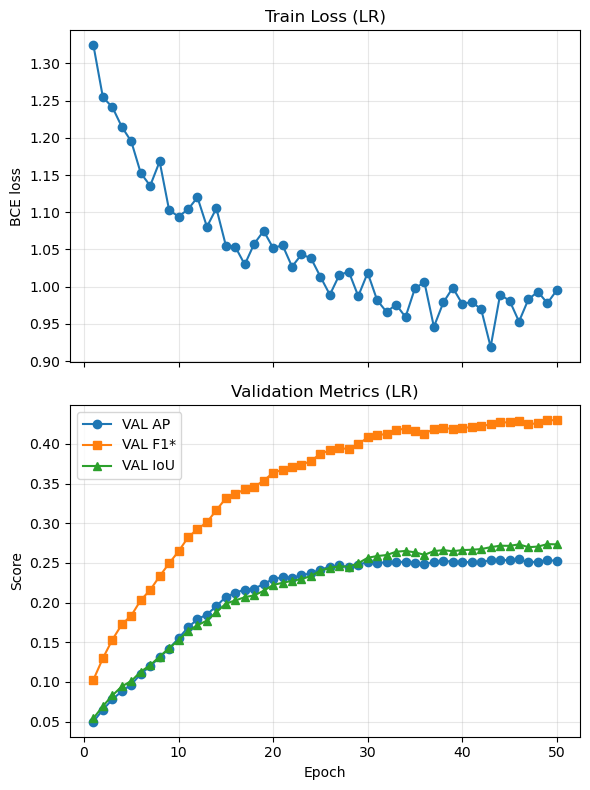

In [23]:
if not train_loss_hist:
    print("Training history empty — load skipped training or artifact lacks history. Run the training cell without a cached model to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (LR)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    if val_iou_hist:
        axes[1].plot(metric_epochs, val_iou_hist, marker="^", label="VAL IoU")
    axes[1].set_title("Validation Metrics (LR)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()

In [24]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         22
  Avg. epoch wall time         0.688 s
  Epoch time stdev             0.045 s
  Training throughput          1743.898 tiles/s
  Peak GPU memory              —
  Inference latency (1 tile)   0.212 ms


In [25]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.4942
  gust_med         +0.3600
  erc              +0.2623
  wind_75          -0.2583
  pdsi             -0.2462
  barrier          -0.2294
  temp             +0.1967
  bi               +0.1941
  fuel2            +0.1090
  rh               -0.1058
  water            -0.1050
  slope            +0.0761
  ... (+9 more)
[LR] Bias: -0.6700


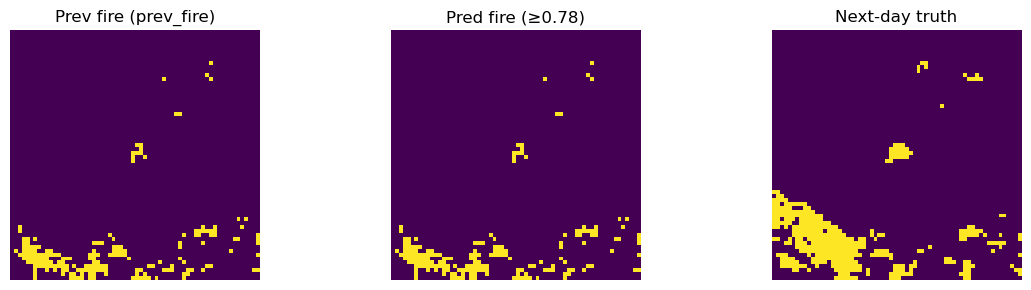

In [26]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

# Example
show_one_lr(test_ds, i=0)

In [27]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /Users/queclay/wildfire_artifacts/lr/pixel_logreg.pt


In [28]:
test_ap_lr, test_f1_lr, test_iou_lr

(0.23401248040019057, 0.41297802259147404, 0.2602219973812254)

In [29]:
# =========================================================
# Final validation/test metrics (LR baseline)
# =========================================================
variants = {"Raw": lr_model}

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_lr(val_loader, model=model_obj, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_lr(test_loader, model=model_obj, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}",
    )

VAL Raw:   0%|          | 0/19 [00:00<?, ?it/s]

TEST Raw:   0%|          | 0/19 [00:00<?, ?it/s]

Final metrics (val/test):
  Raw    | VAL AP 0.2544 F1 0.4295 IoU 0.2735 thr≈0.781 | TEST AP 0.2340 F1 0.4131 IoU 0.2604


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2544 F1*=0.4295 IoU=0.2735 thr≈0.781
VAL @thr: {'tp': 16762, 'fp': 23993, 'tn': 1167502, 'fn': 20543, 'precision': 0.4112869586552788, 'recall': 0.44932314703110865, 'f1': 0.4294645094857008, 'iou': 0.2734510098208305}
TEST @thr: {'tp': 17489, 'fp': 28378, 'tn': 1161592, 'fn': 21341, 'precision': 0.3812981010311594, 'recall': 0.45039917589481065, 'f1': 0.41297802259147404, 'iou': 0.2602219973812254}
VAL @thr: {'tp': 16762, 'fp': 23993, 'tn': 1167502, 'fn': 20543, 'precision': 0.4112869586552788, 'recall': 0.44932314703110865, 'f1': 0.4294645094857008, 'iou': 0.2734510098208305}
TEST @thr: {'tp': 17489, 'fp': 28378, 'tn': 1161592, 'fn': 21341, 'precision': 0.3812981010311594, 'recall': 0.45039917589481065, 'f1': 0.41297802259147404, 'iou': 0.2602219973812254}


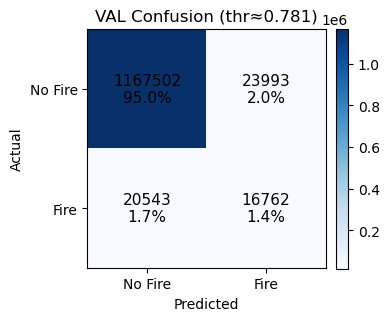

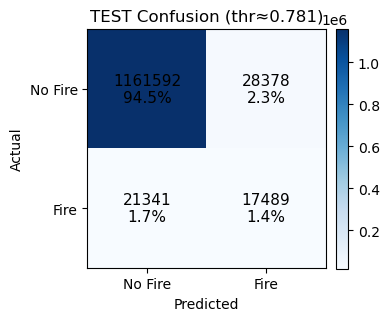

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val, val_iou = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} IoU={val_iou:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    iou  = tp / (tp + fp + fn + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1), iou=float(iou))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))

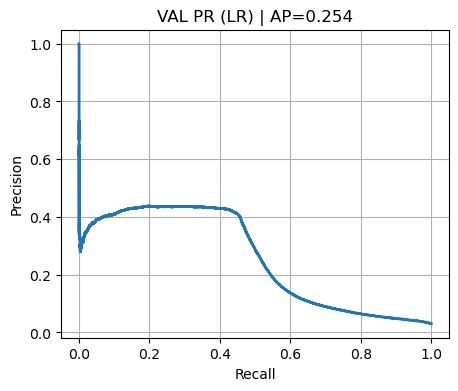

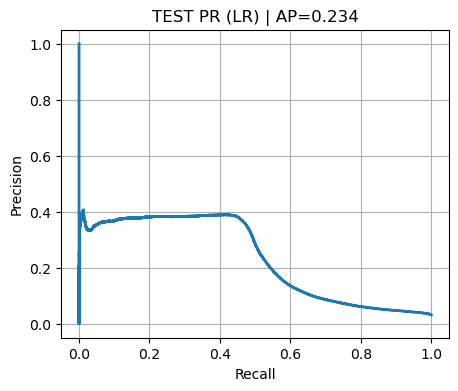

In [31]:
import matplotlib.pyplot as plt
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True); plt.show()

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [32]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  pr                AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  chili             AP=0.029  F1*=0.059
